# Transcription Tools 

Link to the [Documentation / Test Plateform](http://biggerboi.linto.ai:8000/docs/#/)

3 different calls:
1. `POST /transcribe` (Text To Speech)
```
curl -X 'POST' \
  'http://biggerboi.linto.ai:8000/transcribe' \
  -H 'accept: application/json' \
  -H 'Content-Type: multipart/form-data' \
  -F 'file=@A_Mic1.mp3;type=audio/mpeg' \
  -F 'transcriptionConfig={
  "enablePunctuation": false,
  "diarizationConfig": {
    "enableDiarization": false,
    "numberOfSpeaker": 1,
    "maxNumberOfSpeaker": 2
  }
}' \
  -F 'force_sync=false'
```
returns `{"jobid": "5623661d-fe46-4881-aef4-aeaeef46ae06"}` (Response Body if code = 201) or directly the result JSON (code = 200)


2. `GET /job/{jobid}`
```
curl -X 'GET' \
  'http://biggerboi.linto.ai:8000/job/5623661d-fe46-4881-aef4-aeaeef46ae06' \
  -H 'accept: application/json'
```
returns 201 if finished (contains `result_id`), 202 if still in process

3. `GET /results/{result_id}`
```
curl -X 'GET' \
  'http://biggerboi.linto.ai:8000/results/883ff41f-e5fb-439b-8109-1ca49091e75d?convert_numbers=false&return_raw=false' \
  -H 'accept: application/json'
```
returns 200 and JSON if finished

In [100]:
import requests
import json
import time
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

## Calling API

In [21]:
SOURCE_URL = "http://biggerboi.linto.ai:8000"
HEADER = {'accept': 'application/json'}

def post_file_transcribe(file_path:str, transcription_config:dict):
    # Config
    files = {
        "file": open(file_path, "rb")
    }

    data = {
    "transcriptionConfig": json.dumps(transcription_config)
    }
    # Send
    response = requests.post(f"{SOURCE_URL}/transcribe", files=files, data=data, headers = HEADER)
    # Response
    if response.status_code == 201:
        jobid = response.json()['jobid']
        res = {'state':'process'}
        while res['state'] != 'done':
            time.sleep(5)
            response = requests.get(f"{SOURCE_URL}/job/{jobid}", headers = HEADER)
            res = response.json()
        result_id = res['result_id']
        response = requests.get(f"{SOURCE_URL}/results/{result_id}", headers = HEADER)
    if response.status_code == 200:
        transc = response.json()
        # transc.keys()
        # dict_keys(['transcription_result', 'raw_transcription', 'confidence', 'segments'])
        # transc['segments'].keys()
        # dict_keys(['spk_id', 'start', 'end', 'duration', 'raw_segment', 'segment', 'words'])
        #print(pd.DataFrame(transc['segments'][0]['words']))
        return transc
    else:
        return response.text

#### Tests

In [36]:
# Config
files = {
    "file": open(filename, "rb")
}

data = {
"transcriptionConfig": json.dumps(config)
}
# Send
response = requests.post(f"{SOURCE_URL}/transcribe", files=files, data=data, headers = HEADER)
# Response
if response.status_code == 201:
    jobid = response.json()['jobid']
    res = {'state':'process'}
else:
    print(response.text)

In [37]:
response = requests.get(f"{SOURCE_URL}/job/{jobid}", headers = HEADER)
res = response.json()
res

{'state': 'done', 'result_id': '3b309eee-661f-44dc-b436-822c042667ab'}

In [39]:
result_id = res['result_id']
response = requests.get(f"{SOURCE_URL}/results/{result_id}", headers = HEADER)
if response.status_code == 200:
    transc = response.json()
else:
    print(response.text)

#### Apply

In [34]:
filename = 'A_Mic2.mp3'

config = {
    "enablePunctuation": False,
    "diarizationConfig": {
        "enableDiarization": False,
        "numberOfSpeaker": 1,
        "maxNumberOfSpeaker": 5
}}

For some reason not working - yet all steps work :shrug:

In [ ]:
transc = post_file_transcribe(filename, config)
if isinstance(transc, dict):
    print('Transcription OK')
else:
    print(transc)


## Parsing JSON to CSV / TextGrid

In [40]:
#transc.keys()
transc['segments'][0].keys(), len(transc['segments'])
#pd.DataFrame(transc['segments'][0]['words'])

(dict_keys(['spk_id', 'start', 'end', 'duration', 'raw_segment', 'segment', 'words']),
 1)

In [44]:
df = []
for t in transc['segments']:
    #print(t['spk_id'], t['start'], t['end'], t['duration'], len(t['words']))
    tmp = pd.DataFrame(t['words'])
    tmp['spk_id'] = t['spk_id']
    df.append(tmp)
df = pd.concat(df, axis=0).reset_index(drop=True)
print(df.shape, df.spk_id.unique())
df.head()

(3930, 5) [None]


,word,start,end,conf,spk_id
0,hum,6.481485,6.660000,0.550166,None
1,ah,7.170211,7.500402,0.393780,None
2,non,7.500927,7.650153,0.413070,None
3,j',7.664348,7.741463,0.318835,None
4,avais,7.746179,7.889332,0.399175,None


In [12]:
import sys, os, inspect

sys.path.append('/Users/eliot/Documents/tools/SPPAS')
sys.path.append('/Users/eliot/Documents/projects/multimodal-grounding/multimodalgrounding/utils/')

In [46]:
%%capture
from sppasfunc import interval_to_textgrid, read_ipus

In [45]:
unique_spk = df.spk_id.unique()

if len(unique_spk) > 1:
    for spk in unique_spk:
        interval_to_textgrid(df[df.spk_id == spk], filename.replace('mp3','TextGrid'), 
                        annot_tier=f'word-{spk}', text_column='word',
                        timestart_col='start', timestop_col='end')
else:
    interval_to_textgrid(df, filename.replace('mp3','TextGrid'), 
                        annot_tier='word', text_column='word',
                        timestart_col='start', timestop_col='end')

## Comparison 2-channels vs 2 1-channel

In [53]:
# Two separate files
df_sep = []
for spk in [1,2]:
    filename = f'A_Mic{spk}.TextGrid'
    tmp, _ = read_ipus(filename, 'word')
    tmp['spk_id'] = spk
    df_sep.append(tmp)

df_sep = pd.concat(df_sep, axis=0).reset_index(drop=True)

# Two channels together
df_two = []
for spk in [1,2]:
    tmp, _ = read_ipus('audio.TextGrid', f"word-spk{spk}")
    tmp['spk_id'] = spk
    df_two.append(tmp)

df_two = pd.concat(df_two, axis=0).reset_index(drop=True)

In [54]:
df_sep.shape, df_two.shape

((8407, 6), (4822, 6))

In [61]:
df_sep.head(2)

,annotation,label,start_time,stop_time,location,spk_id
0,76aaea60-3469-4eee-a7be-1b5624499080 [(7.43999...,ah,7.440000,7.500164,"[(7.4399999999999995, 0.0005),(7.500164, 0.0005)]",1
1,9b6a2f95-f034-485f-a2b8-ff72d91cc765 [(7.50456...,non,7.504561,7.649958,"[(7.504561, 0.0005),(7.649958, 0.0005)]",1


Matching cells & checking, for those not matched, the intensity. For those matched, checking whether speaker is correct.

In [86]:
def merge_about(df_left:pd.DataFrame, df_right:pd.DataFrame, diff_time:float=0.3) -> pd.DataFrame:
    """Merging right df into left (left is ref and has more rows than right)
    """
    df = df_left[['spk_id', 'start_time', 'stop_time', 'label']]
    for col in df.columns:
        df[f'{col}_2c'] = None
    for idx, row in tqdm(df.iterrows()):
        tmp = df_right[(df_right.start_time >= (row.start_time - diff_time)) & (df_right.stop_time <= (row.stop_time + diff_time))]
        if tmp.shape[0] > 0:
            df.iloc[idx, df.columns.get_loc('label_2c')] = ' '.join(tmp.label.to_list())
            df.iloc[idx, df.columns.get_loc('start_time_2c')] = tmp.start_time.min()
            df.iloc[idx, df.columns.get_loc('stop_time_2c')] = tmp.stop_time.max()
            df.iloc[idx, df.columns.get_loc('spk_id_2c')] = tmp.spk_id.iloc[0]
            
    return df

In [87]:
df = merge_about(df_sep, df_two)

/var/folders/kr/m6yb8cr154dcdkxnm75b4clw0000gn/T/ipykernel_81579/1196001615.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_2c'] = None
8407it [00:03, 2582.12it/s]


In [89]:
# Empty - words not strong enough to be heard
df.isna().sum() / df.shape[0]

spk_id           0.000000
start_time       0.000000
stop_time        0.000000
label            0.000000
spk_id_2c        0.046628
start_time_2c    0.046628
stop_time_2c     0.046628
label_2c         0.046628
dtype: float64

In [94]:
# Wrong speaker
(df.spk_id != df.spk_id_2c).sum() / df.shape[0]

0.49791840133222315

In [112]:
# Different word
# !!! Since unprecise matching, will just check if the word is in the label_2c
df.apply(lambda x: (x.label_2c is not None) and (x.spk_id == x.spk_id_2c) and (x.label not in x.label_2c), axis=1).sum() / df.shape[0]

0.07077435470441298

/var/folders/kr/m6yb8cr154dcdkxnm75b4clw0000gn/T/ipykernel_81579/468053916.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['','', 'NA in audio-2channels', 'should be loc 2', 'should be loc 1', '2c / 1c diff words loc 1', '2c / 1c diff words loc 2'])


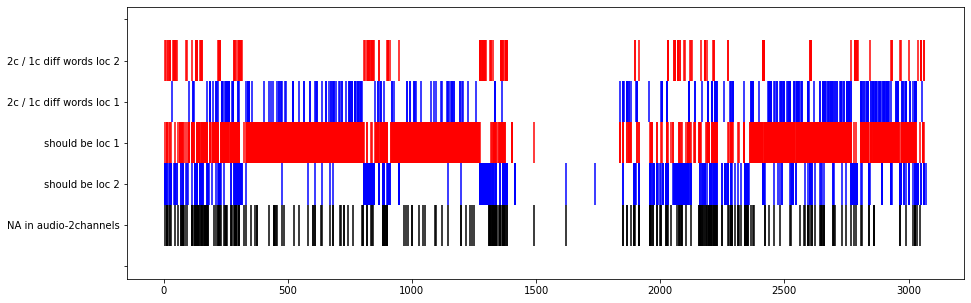

In [114]:
# plot sur la durée de l'expérience
fig, ax = plt.subplots(figsize = (15,5))
# plot NA locations
t = df[df.spk_id_2c.isna()]
events = [t.start_time.tolist()]
# plot Wrong speaker 
for i in [1,2]:
    events.append(df[(df.spk_id != df.spk_id_2c) & (df.spk_id == i)].start_time.tolist())
# plot Different word
diff_w = df.apply(lambda x: (x.label_2c is not None) and (x.spk_id == x.spk_id_2c) and (x.label not in x.label_2c), axis=1)
for i in [1,2]:
    events.append(df[diff_w & (df.spk_id == i)].start_time.tolist())

ax.eventplot(events, colors=['black','blue','red','blue','red'])
ax.set_yticklabels(['','', 'NA in audio-2channels', 'should be loc 2', 'should be loc 1', '2c / 1c diff words loc 1', '2c / 1c diff words loc 2'])
plt.show()